In [1]:
# if this line is not separated from the line below this cell has to be executed twice
# Jupyter Notebook with widget matplotlib plots
%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
#%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pyicon as pyic  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import numpy as np
from netCDF4 import Dataset
import cartopy.crs as ccrs
import seawater as sw
import xarray as xr
import matplotlib.pyplot as plt
import glob
from matplotlib.collections import PatchCollection
from matplotlib.collections import PolyCollection
import os
import re

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots


## Load same basic set as forcing data

Basic set is used to see whether idealized forcing has correct magnitude and to get correct time axis and variable information in netcdf file.

In [3]:
run_base = 'nib1901'
path_data_base = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes/experiments/{run_base}/'


fpath_tgrid = f'{path_data_base}/Ocean_Torus_Triangles_10x10_100000m.nc'
# fpath_fx = f'{path_data}/{run}_fx.nc'
ds_tg = xr.open_dataset(fpath_tgrid)
# ds_fx = xr.open_dataset(fpath_fx)

ds_ini_orig = xr.open_mfdataset(f'{path_data_base}/initial_state.nc')
ds_ini_orig = ds_ini_orig.compute()

ds_flux_orig = xr.open_mfdataset(f'{path_data_base}/ocean-flux.nc')
ds_flux_orig = ds_flux_orig.compute()

In [4]:
ds_flux = ds_flux_orig.copy(deep=True)
ds_ini = ds_ini_orig.copy(deep=True)

## Overwrite forcing and initial data

In [5]:
fvars = list(ds_flux.keys())[2:]
fvars

['cloud',
 'dpt_temp_2m',
 'precip',
 'pressure',
 'runoff',
 'scalar_wind',
 'stress_x',
 'stress_y',
 'temp_2m',
 'tot_solar',
 'u_wnd_10m',
 'v_wnd_10m']

In [6]:
ivars = list(ds_ini.keys())[3:]
ivars

['T', 'S', 'u', 'v']

In [7]:
dt = (ds_flux.time-ds_flux.time[0]).astype(float)*1e-9

Overwrite forcing variables:

In [8]:
for var in fvars:
    ds_flux[var] *= 0.0
ds_flux['dpt_temp_2m'] += 293.15
ds_flux['temp_2m'] += 293.15
# ds_flux['stress_x'] += 0.1
ds_flux['pressure'] += 1016e2
# ds_flux['tot_solar'] += 800*xr.ufuncs.sin(2.*np.pi*dt/86400.)
ds_flux['precip'] += 5e-6
# ds_flux['tot_solar'] += 800
ds_flux['tot_solar'] = xr.where(ds_flux['tot_solar']>0, ds_flux['tot_solar'], 0.)

Overwrite initial variables:

In [9]:
for var in ivars:
    ds_ini[var] *= 0.0
ds_ini['T'] += 20.
ds_ini['S'] += 35.

## Plot old and new forcing and initial data

<IPython.core.display.Javascript object>


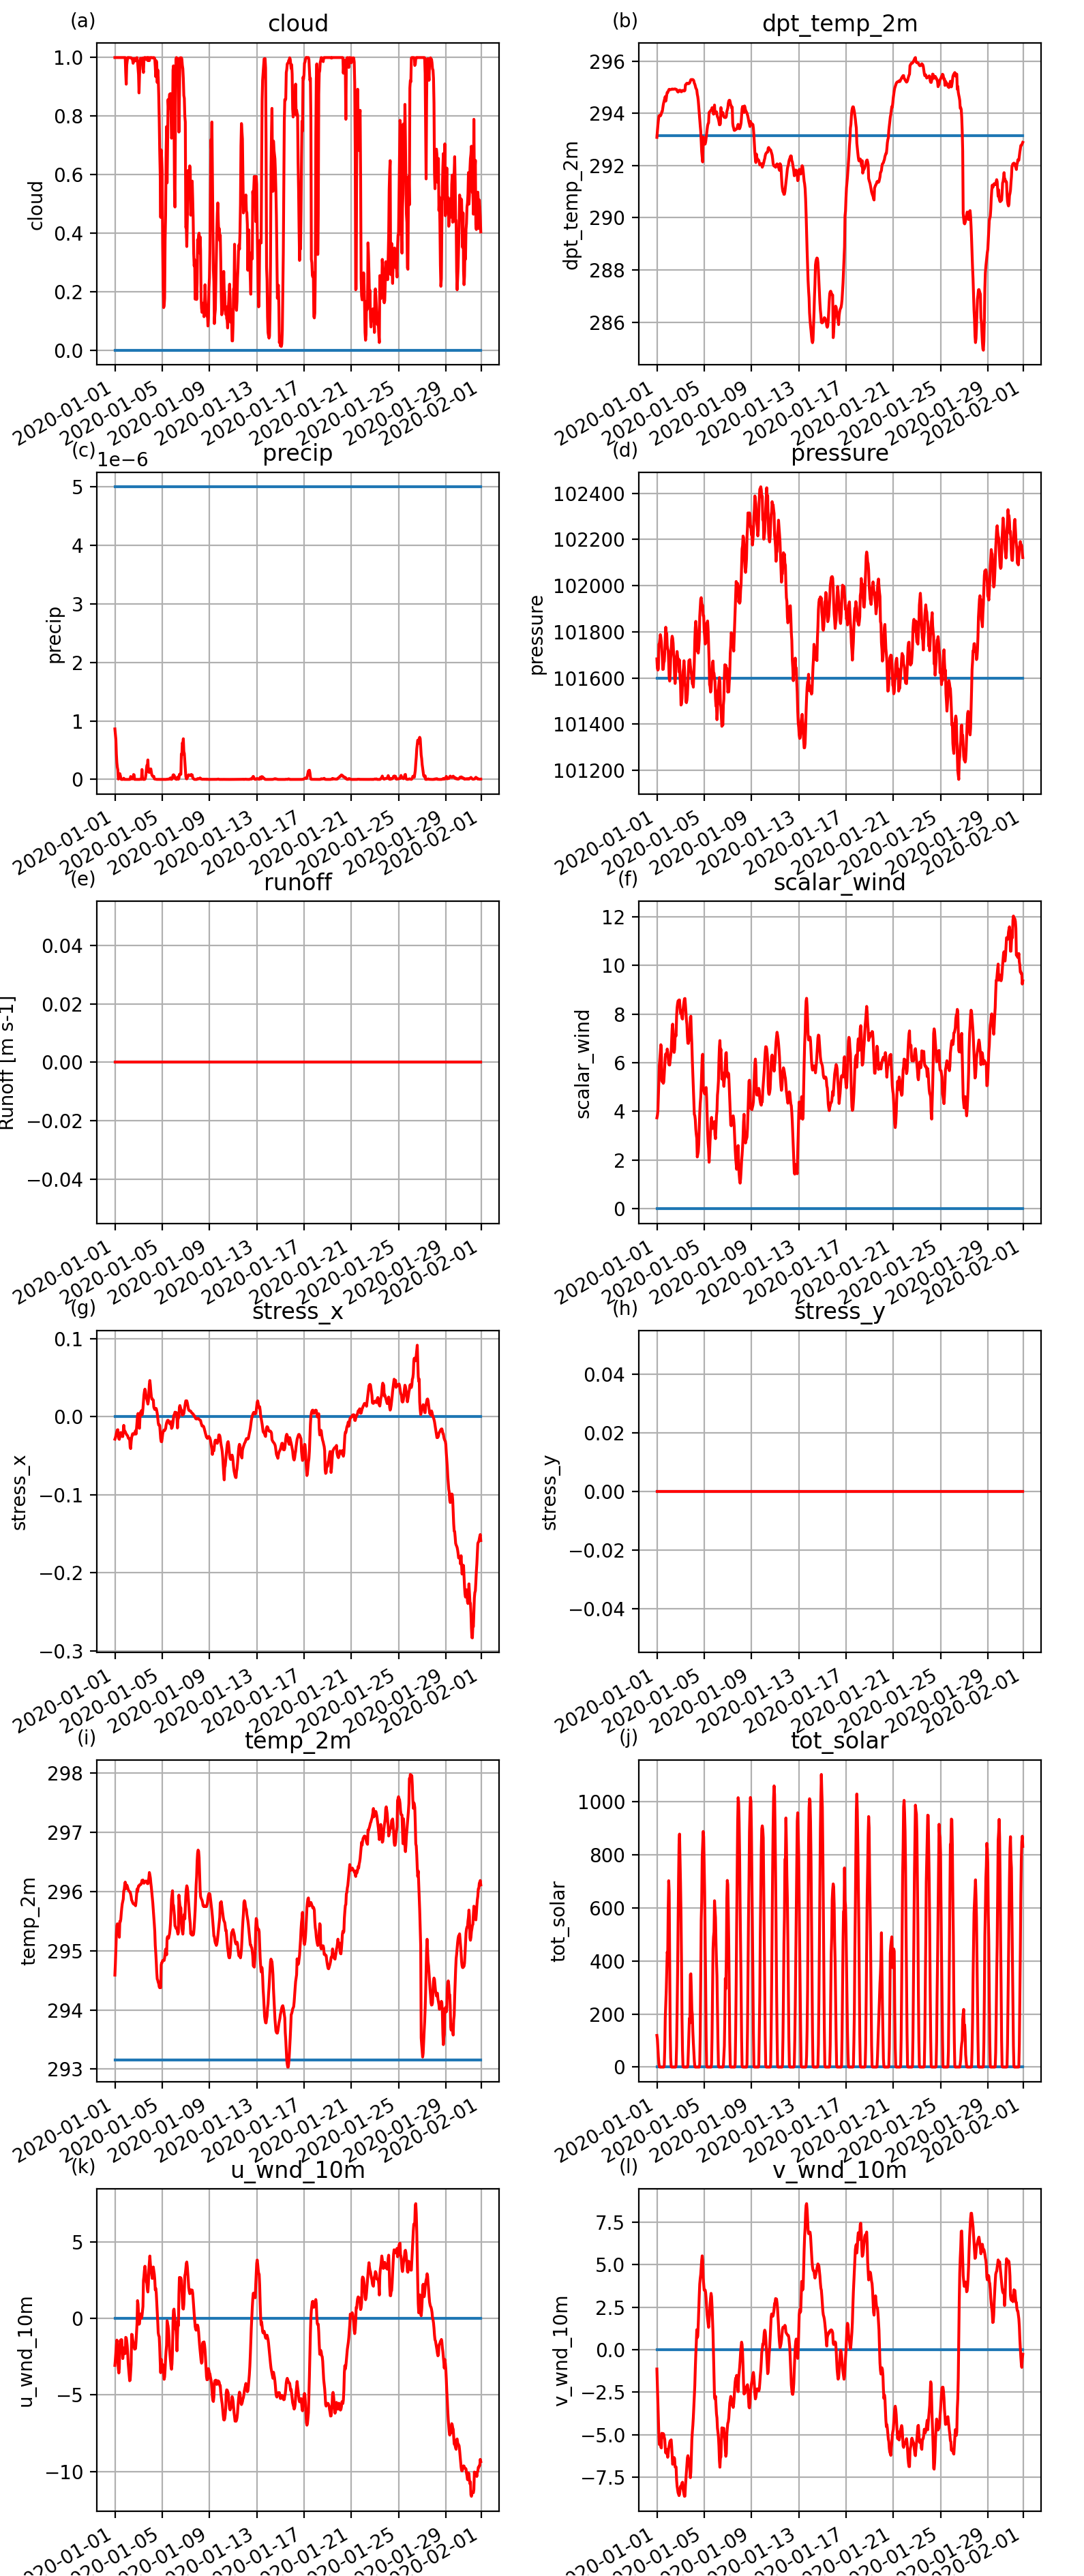

In [10]:
# fig = plt.figure()
# ax = plt.axes()
hca, hcb = pyic.arrange_axes(2,6, plot_cb=False, asp=0.8, fig_size_fac=1.5, sharex=False, sharey=False)
ii=-1

nc = 10

for var in fvars:
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    ds_flux[var].isel(ncells=nc).plot(ax=ax)
    ds_flux_orig[var].isel(ncells=nc).plot(ax=ax, color='r')
    ax.set_title(ds_flux[var].name)
    ax.set_xlabel('')

for ax in hca:
    ax.grid(True)

<IPython.core.display.Javascript object>


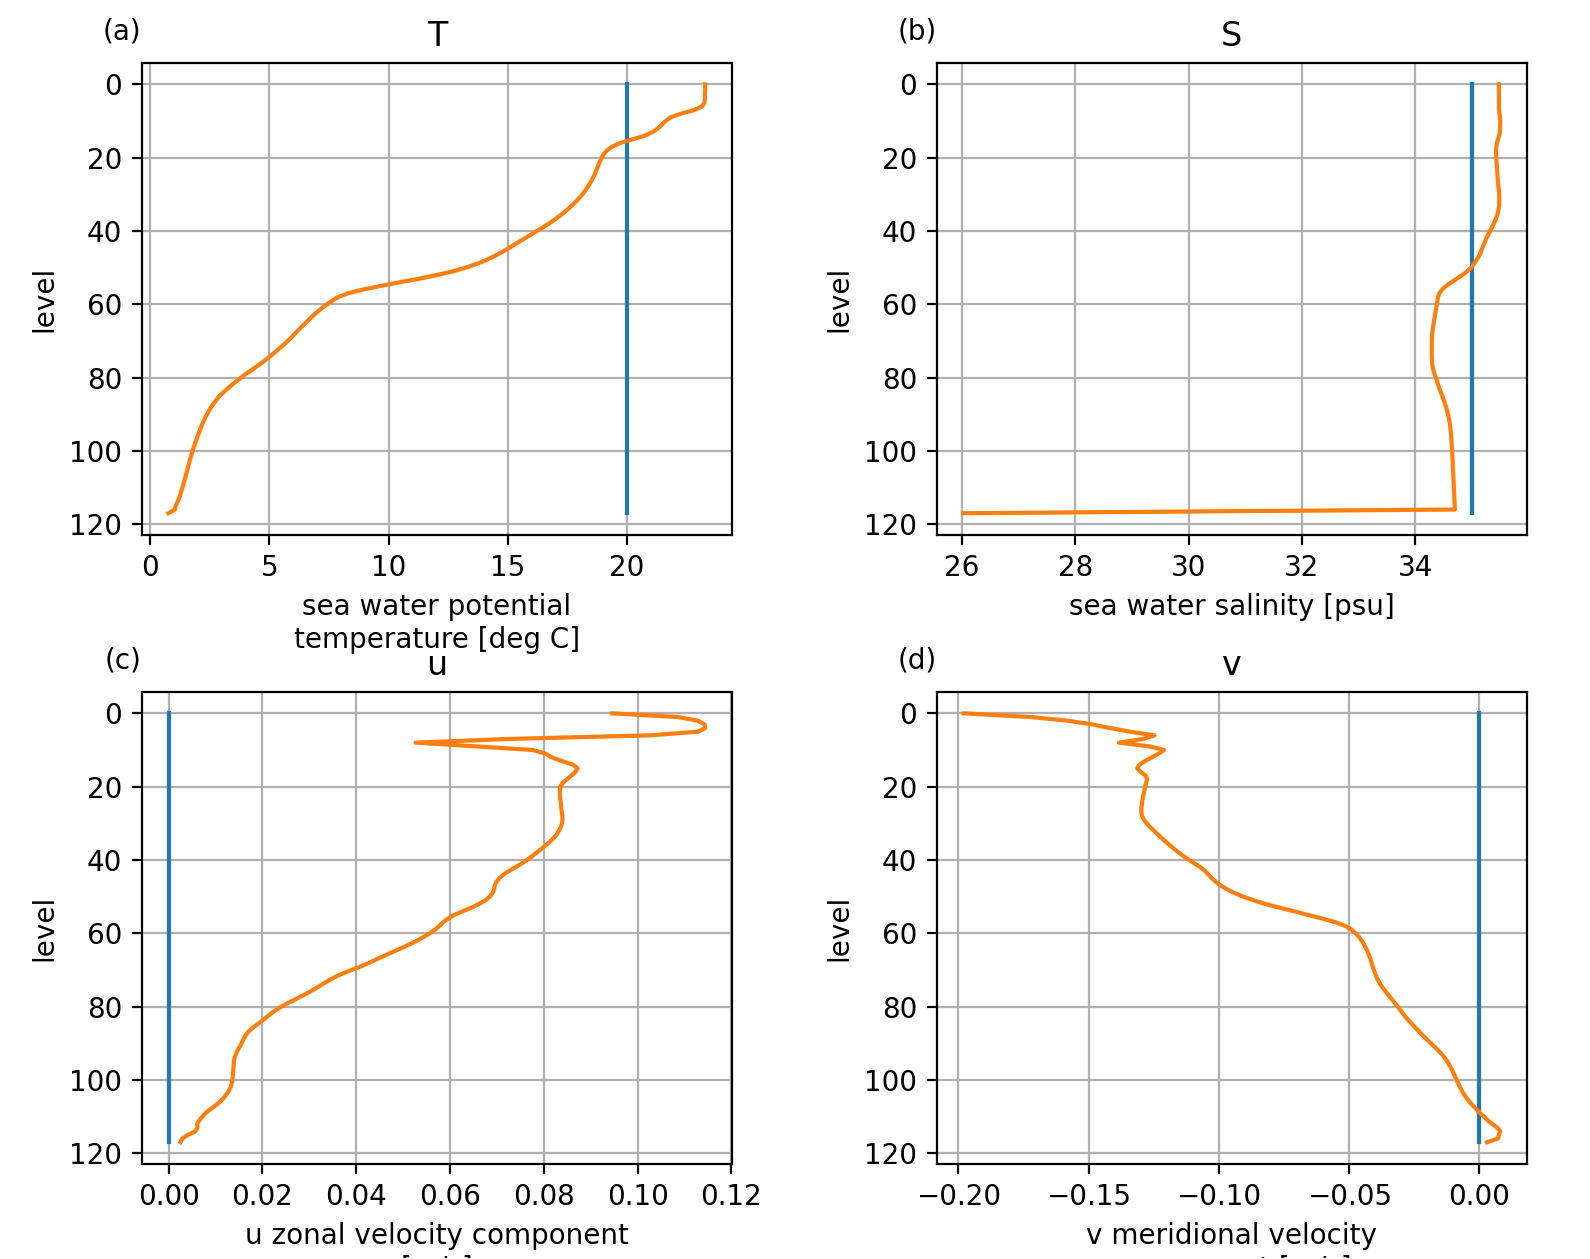

In [11]:
hca, hcb = pyic.arrange_axes(2,2, plot_cb=False, asp=0.8, fig_size_fac=1.5, sharex=False, sharey=False)
ii=-1

nc = 10

for var in ivars:
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    ds_ini[var].isel(ncells=nc).plot(ax=ax, y='level', yincrease=False)
    ds_ini_orig[var].isel(ncells=nc).plot(ax=ax, y='level', yincrease=False)
    ax.set_title(ds_ini[var].name)

for ax in hca:
    ax.grid(True)

## Prepare set of new simulations

In [12]:
path_run = f'/work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes_zstar3_torus/run/'

In [13]:
idbase = 'nib1903_fixsst'
fpath_template = f'{path_run}/exp.{idbase}.run'

In [14]:
class Simulation(object):
    def __init__(self):
        return

In [15]:
Sims = dict()
# id = 1902
id = 1922

# ---
S = Simulation()
id += 1
S.run = f'nib{id}_zlev_sft1_only_precip'
S.vert_cor_type = 0
S.sft = 1
Sims[S.run] = S

S = Simulation()
id += 1
S.run = f'nib{id}_zstar_sft12_only_precip'
S.vert_cor_type = 1
S.sft = 12
Sims[S.run] = S

S = Simulation()
id += 1
S.run = f'nib{id}_zstar_sft14_only_precip'
S.vert_cor_type = 1
S.sft = 14
Sims[S.run] = S

S = Simulation()
id += 1
S.run = f'nib{id}_zstar_sft15_only_precip'
S.vert_cor_type = 1
S.sft = 15
Sims[S.run] = S

In [20]:
master_run_script = '#!/bin/bash\n'
for run, S in Sims.items():
    f = open(fpath_template, 'r')
    txt = f.read()
    f.close()

    txt = re.sub(idbase, S.run, txt)
    txt = re.sub('vert_cor_type = 0', f'vert_cor_type = {S.vert_cor_type}', txt)
    txt = re.sub('surface_flux_type               = 12', f'surface_flux_type               = {S.sft}', txt)

    fpath_out = f'{path_run}/exp.{S.run}.run'
    print(f'Writing file {fpath_out}')
    f = open(fpath_out, 'w')
    f.write(txt)
    f.close()
    os.chmod(fpath_out, 0o744)
    
    path_datao = f'{path_run}/../experiments/{S.run}'
    print(f'{path_datao}')
    if not os.path.exists(path_datao):
        os.makedirs(path_datao)
    ds_flux.to_netcdf(f'{path_datao}/ocean-flux.nc')
    ds_ini.to_netcdf(f'{path_datao}/initial_state.nc')
    
    master_run_script += f'./exp.{run}.run\n'

fpath_master = f'{path_run}/ni_run_all.sh'
print('-----------------------------')
print(f'Writing {fpath_master}')
f = open(fpath_master, 'w')
f.write(master_run_script)
f.close()
os.chmod(fpath_master, 0o744)

Writing file /work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes_zstar3_torus/run//exp.nib1923_zlev_sft1_only_precip.run
/work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes_zstar3_torus/run//../experiments/nib1923_zlev_sft1_only_precip
Writing file /work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes_zstar3_torus/run//exp.nib1924_zstar_sft12_only_precip.run
/work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes_zstar3_torus/run//../experiments/nib1924_zstar_sft12_only_precip
Writing file /work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes_zstar3_torus/run//exp.nib1925_zstar_sft14_only_precip.run
/work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes_zstar3_torus/run//../experiments/nib1925_zstar_sft14_only_precip
Writing file /work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes_zstar3_torus/run//exp.nib1926_zstar_sft15_only_precip.run
/work/mh0033/m300602/proj_vmix/icon/icon_19/icon-oes_zstar3_torus/run//../experiments/nib1926_zstar_sft15_only_precip
-----------------------------
Writin

In [21]:
print(master_run_script)

#!/bin/bash
./exp.nib1923_zlev_sft1_only_precip.run
./exp.nib1924_zstar_sft12_only_precip.run
./exp.nib1925_zstar_sft14_only_precip.run
./exp.nib1926_zstar_sft15_only_precip.run

